# Part1: Text Detection

In [1]:
import paddle
#paddle.utils.run_check()
from paddleocr import PaddleOCR, draw_ocr
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline

### Rotating images to fit the model

In [ ]:
for i in range(9, 10):
    img_path=f'./dataset/train/00{i}.jpg'
    image = Image.open(img_path).convert('RGB')
    image = Image.Image.rotate(image, 270)
    Image.Image.save(image, f'./dataset/rotated/00{i}.png')

## Testing detection on single image

[2025/03/23 08:35:41] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\User/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\User/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_d

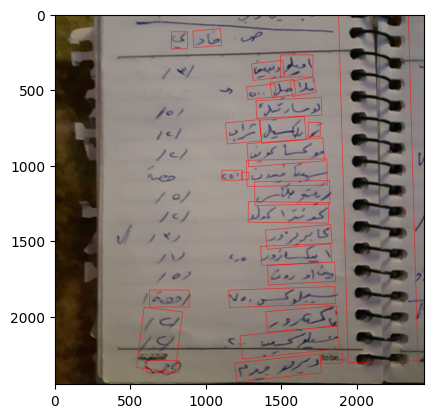

In [ ]:

img_path=r'.\dataset\rotated\006.png'
model_path=r'.\output\det_db_inference'

ocr = PaddleOCR(rec_model_dir=model_path, lang='ar', use_gpu=False, use_angle_cls=True)
result = ocr.ocr(img_path, rec=False) 
#print(result)       
image = Image.open(img_path).convert('RGB')
for box in result:
    im_show = draw_ocr(image, box)
    image = im_show
plt.figure()
plt.imshow(im_show);


## Preprocessing Detected Boxes

In [ ]:
import os
from paddleocr import PaddleOCR
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def centeroid(list):
    arr = np.asanyarray(list)
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

# Configuration
image_dir = r".\dataset\rotated"
model_path = r'.\output\det_db_inference'
output_dir = r".\dataset\merged_results"
os.makedirs(output_dir, exist_ok=True)

# Threshold parameters (idx0 => horizontal, idx1 => vertical)
vertical_threshold = .025  # Max vertical distance to consider boxes on the same line
horizontal_threshold = .2  # Max horizontal gap between boxes to merge
size_tolerence = 20
search_ver_threshold = 100

# Initialize PaddleOCR
ocr = PaddleOCR(rec_model_dir=model_path, lang='ar', use_gpu=False, use_angle_cls=True)

def merge_boxes(boxes, vertical_threshold, horizontal_threshold):
    """
    Merge boxes that are aligned horizontally and within the specified thresholds.
    """
    if not boxes:
        return []

    # Sort boxes by their vertical position (top y-coordinate)
    boxes = sorted(boxes, key=lambda x: centeroid(x)[1])

    merged_boxes = []
    current_box = list(boxes[0])
    current_box_width = abs(current_box[0][0] - current_box[1][0])
    current_box_hight = abs(current_box[0][1] - current_box[3][1])
    c = 0
    while current_box_hight > current_box_width or current_box_width < size_tolerence:
        c+=1
        current_box = list(boxes[c])
        current_box_width = abs(current_box[0][0] - current_box[1][0])
        current_box_hight = abs(current_box[0][1] - current_box[3][1])
    
    while c < len(boxes):
        candidates = [box for box in boxes[c+1:] if abs(centeroid(box)[1] - centeroid(current_box)[1]) < search_ver_threshold]
        for box in candidates:
            # Check if the next box is on the same line (vertical threshold)
            box_width = abs(box[0][0] - box[1][0])
            box_hight = abs(box[0][1] - box[3][1])
            current_box_width = abs(current_box[0][0] - current_box[1][0])
            current_box_hight = abs(current_box[0][1] - current_box[3][1])
            
            if box_hight > box_width or box_width < size_tolerence:
                # false detection
                continue
            
            # box sequence: top-left => top-right => down-left => down-right
            horizontal_threshold = 1.5* max(box_width, current_box_width)
            vertical_threshold = .5*max(box_hight, current_box_hight)
                
            if abs(centeroid(box)[1] - centeroid(current_box)[1]) < vertical_threshold:
                # box_to_right = centeroid(box)[0] - centeroid(current_box)[0] > 0
                # if (not box_to_right and abs(box[0][0] - current_box[1][0]) < max(box_width, current_box_width)) \
                #     or (box_to_right and abs(box[1][0] - current_box[0][0]) < max(box_width, current_box_width)):
                #     # box contained in current box
                #     continue
                
                if abs(centeroid(box)[0] - centeroid(current_box)[0]) < .25*max(box_width, current_box_width):
                    continue
                
                # Check if the next box is close enough horizontally to merge
                if abs(centeroid(box)[0] - centeroid(current_box)[0]) < horizontal_threshold:
                    # Merge boxes by expanding the current box
                    current_box[0][0] = min(current_box[0][0], box[0][0])  # Leftmost x
                    current_box[1][0] = max(current_box[1][0], box[1][0])  # Rightmost x
                    current_box[2][0] = max(current_box[2][0], box[2][0])  # Rightmost x
                    current_box[3][0] = min(current_box[3][0], box[3][0])  # Leftmost x
                    current_box[0][1] = min(current_box[0][1], box[0][1])  # Topmost y
                    current_box[1][1] = min(current_box[1][1], box[1][1])  # Topmost y
                    current_box[2][1] = max(current_box[2][1], box[2][1])  # Bottommost y
                    current_box[3][1] = max(current_box[3][1], box[3][1])  # Bottommost y
                else:
                    # Add the current merged box and start a new one
                    merged_boxes.append(current_box)
                    current_box = list(box)
            else:
                # Add the current merged box and start a new one
                merged_boxes.append(current_box)
                current_box = list(box)

    # Add the last merged box
    merged_boxes.append(current_box)

    return merged_boxes

def process_image(image_path, output_path):
    # Run detection
    result = ocr.ocr(image_path, rec=False)
    boxes = [box for box in result[0]]  # Extract bounding boxes

    # Merge boxes
    merged_boxes = merge_boxes(boxes, vertical_threshold, horizontal_threshold)

    # Visualize results
    image_orig = Image.open(image_path).convert('RGB')
    draw_orig = ImageDraw.Draw(image_orig)
    image_merg = Image.open(image_path).convert('RGB')
    draw_merg = ImageDraw.Draw(image_merg)

    # Draw original boxes in red
    for box in boxes:
        draw_orig.polygon([tuple(point) for point in box], outline='red', width=7)

    # Draw merged boxes in green
    for box in merged_boxes:
        draw_merg.polygon([tuple(point) for point in box], outline='green', width=7)

    # Save and display
    image_merg.save(output_path)
    _, axarr = plt.subplots(1,2, figsize=(8, 16))
    axarr[1].imshow(image_orig)
    axarr[0].imshow(image_merg)
    plt.title(f"Merged Boxes: {os.path.basename(image_path)}")
    plt.show()

# Process all images in the directory
for filename in os.listdir(image_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_dir, filename)
        output_path = os.path.join(output_dir, filename)
        process_image(image_path, output_path)

print(f"Processing complete. Results saved to: {output_dir}")

[2025/03/23 15:25:20] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\User/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\User/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_d

# Part2: Text Classification

### Step 1: Data Preparation

In [ ]:
import os
import cv2
import numpy as np
import paddle
from paddle.io import Dataset, DataLoader
from paddle.vision.transforms import Compose, Resize, Normalize
from paddle.nn import Linear, CrossEntropyLoss
from paddle.optimizer import Adam
from paddle.metric import Accuracy

# Configuration
data_dir = r".\dataset"
output_dir = r".\dataset\classification"
image_size = (64, 32)  # Resize all text regions to this size
num_classes = 200  # Number of words to classify
batch_size = 32
epochs = 500
learning_rate = 0.001

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Class mapping (word to label)
class_mapping = {}  # Will be populated dynamically
class_counter = 0

# Transformations
transform = Compose([
    Resize(image_size),
    Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values to [-1, 1]
])

# Custom Dataset
class TextClassificationDataset(Dataset):
    def __init__(self, data_dir, split, transform=None):
        self.data_dir = os.path.join(data_dir, split)
        self.label_dir = os.path.join(data_dir, f"{split}.txt")
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        global class_counter

        # Read the label file
        with open(self.label_dir, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split('\t')
            if len(parts) < 2:
                continue

            img_path = parts[0]
            annotations = eval(parts[1])  # Parse the list of annotations

            # Load the image
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Warning: Could not load image {img_path}. Skipping.")
                continue

            # Process each annotation
            for ann in annotations:
                transcription = ann['transcription']
                points = ann['points']

                # Update class mapping
                if transcription not in class_mapping:
                    class_mapping[transcription] = class_counter
                    class_counter += 1

                # Crop the text region
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]
                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)
                cropped_image = image[y_min:y_max, x_min:x_max]

                # Skip invalid regions
                if cropped_image.size == 0:
                    print(f"Warning: Invalid region in {img_path}. Skipping.")
                    continue

                # Add to samples
                samples.append((cropped_image, class_mapping[transcription]))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, label = self.samples[idx]
        if self.transform:
            image = self.transform(image)
        return image.astype('float32'), np.array(label, dtype='int64')

# Create datasets
train_dataset = TextClassificationDataset(data_dir, 'train', transform)
val_dataset = TextClassificationDataset(data_dir, 'val', transform)
test_dataset = TextClassificationDataset(data_dir, 'test', transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Step 2: Define the Fully Connected Neural Network (FCNN)

In [23]:
class TextClassifier(paddle.nn.Layer):
    def __init__(self, input_size, num_classes):
        super(TextClassifier, self).__init__()
        self.flatten = paddle.nn.Flatten()
        self.fc1 = Linear(input_size, 512)
        self.fc2 = Linear(512, 256)
        self.fc3 = Linear(256, num_classes)
        self.relu = paddle.nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
input_size = image_size[0] * image_size[1]  # Flattened image size
model = TextClassifier(input_size, num_classes)

### Step 3: Training the Model

In [ ]:
# Loss and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(learning_rate=learning_rate, parameters=model.parameters())

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()

        # Metrics
        train_loss += loss.numpy()
        train_acc += Accuracy().compute(outputs, labels).numpy()[0]

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    for images, labels in val_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.numpy()
        val_acc += Accuracy().compute(outputs, labels).numpy()[0]

    # Print epoch results
    print(f"Epoch [{epoch + 1}/{epochs}]")
    print(f"Train Loss: {train_loss / len(train_loader)}, Train Acc: {train_acc / len(train_loader)}")
    print(f"Val Loss: {val_loss / len(val_loader)}, Val Acc: {val_acc / len(val_loader)}")

### Step 4: Testing the Model

In [27]:
model.eval()
test_acc = 0.0

for images, labels in test_loader:
    outputs = model(images)
    test_acc += Accuracy().compute(outputs, labels).numpy()[0]

print(f"Test Accuracy: {test_acc / len(test_loader)}")

Test Accuracy: [0.]


In [28]:
paddle.save(model.state_dict(), os.path.join(output_dir, 'text_classifier.pdparams'))